In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from random import shuffle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import time
import pickle
from scipy.ndimage.measurements import label
%matplotlib inline

# Data Exploration

In [2]:
#The function is from Lesson 19 - Data Exploration 
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [3]:
#Load and shuffle the data
car_images = glob.glob("vehicles/vehicles/*/*.*")
noncar_images = glob.glob("non-vehicles/non-vehicles/*/*.*")
shuffle(car_images)
shuffle(noncar_images)
data_look(car_images, noncar_images)

{'data_type': dtype('float32'),
 'image_shape': (64, 64, 3),
 'n_cars': 8792,
 'n_notcars': 8968}

In [4]:
#The function is from Lesson 5 - Manual Vehicle Detection
#Define a function to draw bounding boxes on an image
def draw_bb(image, bboxes, color=(0,0,255), thickness=6):
    #Make a copy of the image
    imcopy=np.copy(image)
    #Iterate through the bounding boxes
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thickness)
    return imcopy

# Histograms of Color

The goal is to write a function that takes an image and computes the RGB color histogram of features given a particular number of bins and pixels intensity range, and returns the concatenated RGB feature vector

In [5]:
#The function is inspired by Lesson 12- Histogram of Colors 
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), chist_flag=False):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    if(chist_flag==True):
    # Return the individual histograms, bin_centers and feature vector
        return rhist, ghist, bhist, bin_centers, hist_features
    else:
        return hist_features

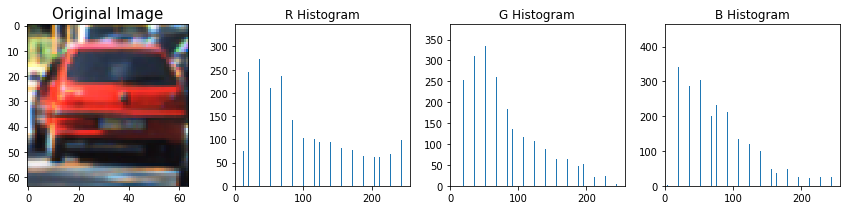

In [6]:
image = cv2.imread('vehicles/vehicles/KITTI_extracted/889.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256), chist_flag=True)
# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Original Image', fontsize=15)
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

# Spatial Binning 

In [7]:
#The function is inspired by Lesson 16 - Spatial Binning
# Define a function that allows me to convert any test image into a feature vector that I can feed
#to my classifier
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# HOG features extraction and visualization

The scikit-image package has a built in function to extract Histogram of Oriented Gradient features. The scikit-image hog() function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include orientations, pixels_per_cell and cells_per_block.
The number of orientations is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The pixels_per_cell parameter specifies the cell size over which each gradient histogram is computed. This paramater is passed as a 2-tuple so I could have different cell sizes in x and y, but cells are commonly chosen to be square.

The cells_per_block parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

In [8]:
#The function is from Lesson 20 - scikit-image HOG
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

Visualize HOG features of a car-image

C:\Users\sando\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


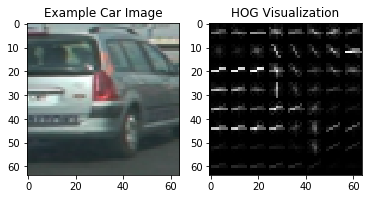

In [9]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(car_images))
# Read in the image
image = mpimg.imread(car_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 16
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Combine and Normalize Features

Now that we've studied several feature extraction methods, we're almost ready to train a classifier, but first, as in any machine learning application, we need to normalize our data. Python's sklearn package provides us with the StandardScaler() method to accomplish this task. 
To apply StandardScaler() we need to first have our data in the right format, as a numpy array where each row is a single feature vector. 
Our goal is to write a function that takes in a list of image filenames, reads them one by one, then applies a color conversion (if necessary) and uses bin_spatial() and color_hist() to generate feature vectors. 

In [10]:
#The function is inspired by Lesson 22 & 29 - Combine and Normalize Features 
#The function includes all feature extraction methodsdiscussed and implemented above
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist() and get_hog_features()
from tqdm import tqdm
def extract_features(images, color_space='YCrCb', spatial_size=(32, 32), 
                     hist_bins=32, orient=16, pix_per_cell=8,
                     cell_per_block=2, hog_channel='ALL',
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) 
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In order to train the SVM by using the spatial binning and color features first then the HOG features, I extract these two feature sets using the car and non-car images defined above

In [11]:
cars = []
notcars = []
for image in car_images:
        cars.append(image)
for image in noncar_images:
        notcars.append(image)
    
#Extract spatial binning and color features
car_features = extract_features(cars, spatial_feat=True, hist_feat=True)
notcar_features = extract_features(notcars, spatial_feat=True, hist_feat=True)

#Extract HOG features
car_features_hog = extract_features(car_images, hog_feat=True)
notcar_features_hog = extract_features(noncar_images, hog_feat=True)

  0%|                                                                                         | 0/8792 [00:00<?, ?it/s]C:\Users\sando\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:55<00:00, 161.63it/s]


# Color histogram SVM Classifier

Now we'll try training a classifier on our dataset. First, we'll see how well it does just using spatially binned color and color histograms.

In [12]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

#Now, you're ready to define and train a classifier! Here we'll try a Linear Support Vector Machine. 
#To define and train your classifier it takes just a few lines of code:

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
#Train the SVC
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')
print('Feature vector length:', len(X_train[0]))

26.77 seconds to train SVC.
Feature vector length: 12576


In [13]:
#Then you can check the accuracy of your classifier on the test dataset like this:
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
t = time.time()
print('My SVC predicts: ', svc.predict(X_test[0:10]))
print('For labels: ', y_test[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy of SVC =  0.989583333333
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]
For labels:  [ 0.  1.  1.  0.  0.  0.  1.  1.  1.  0.]

0.03409 seconds to predict 10 labels with SVC.


# HOG SVM Classifier

Alright, so classification by color features alone is pretty effective! Now let's try classifying with HOG features and see how well we can do.

In [14]:
# Define a labels vector based on features lists
y_hog = np.hstack((np.ones(len(car_features_hog)), 
              np.zeros(len(notcar_features_hog))))
# Create an array stack of feature vectors
X_hog = np.vstack((car_features_hog, notcar_features_hog)).astype(np.float64)
# Fit a per-column scaler
X_scaler_hog = StandardScaler().fit(X_hog)
# Apply the scaler to X
scaled_X_hog = X_scaler_hog.transform(X_hog)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(
    scaled_X_hog, y_hog, test_size=0.2, random_state=rand_state)

#Now, you're ready to define and train a classifier! Here we'll try a Linear Support Vector Machine. 
#To define and train your classifier it takes just a few lines of code:

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc_hog = LinearSVC()
# Check the training time for the SVC
t=time.time()
#Train the SVC
svc_hog.fit(X_train_hog, y_train_hog)
t2 = time.time()

print(round(t2-t, 2), 'seconds to train SVC.')
print('Using:', orient, 'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train_hog[0]))

27.44 seconds to train SVC.
Using: 16 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 12576


In [15]:
#Then you can check the accuracy of your classifier on the test dataset like this:
print('Test Accuracy of SVC = ', svc_hog.score(X_test_hog, y_test_hog))
t = time.time()
print('My SVC predicts: ', svc_hog.predict(X_test_hog[0:10]))
print('For labels: ', y_test_hog[0:10])
t2 = time.time()
print()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy of SVC =  0.989864864865
My SVC predicts:  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]
For labels:  [ 1.  0.  1.  1.  0.  1.  0.  0.  1.  1.]

0.0361 seconds to predict 10 labels with SVC.


# Sliding Window Implementation

My goal here is to write a function that takes in an image, start and stop positions in both x and y (imagine a bounding box for the entire search region), window size (x and y dimensions), and overlap fraction (also for both x and y). My function returns a list of bounding boxes for the search windows, which will then be passed to draw draw_bb() function defined above.

In [16]:
#The function is from Lesson 32 - Sliding Window implementation
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Example of plotted windows on the relevant image region

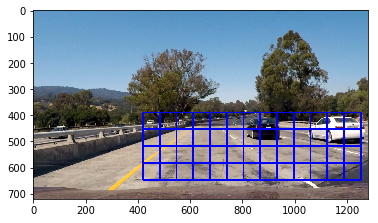

In [17]:
image = cv2.imread('test_images/test1.jpg')
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
windows = slide_window(image, x_start_stop=[420, None], y_start_stop=[390, 680], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_bb(image, windows, color=(0, 0, 255), thickness=6)                    
plt.imshow(window_img)

# Define a function to extract features from a single image

Now I'm able to run a sliding window search on an image and I'm trained a classifier... time to combine both steps and search for cars!

In [18]:
#The function is from Lesson 34 - Search and Classify
# Define a function to extract features from a single image window
# This function is very similar to get_hc_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=16, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [19]:
#The function is from Lesson 34 - Search and Classify
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=16, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Train the classifier and test the classification on a test image

In [20]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [390, 680] # Min and max in y to search in slide_window()
x_start_stop = [400, 1280]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

  0%|                                                                                         | 0/8792 [00:00<?, ?it/s]C:\Users\sando\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [01:18<00:00, 113.95it/s]


In [21]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,
                                                    random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
from sklearn.svm import LinearSVC
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = {0:.2f}%'.format(round(svc.score(X_test, y_test)*100, 4)))
# Check the prediction time for a single sample
t=time.time()

Using: 16 orientations, 8 pixels per cell and 2 cells per block
Feature vector length: 12576
58.69 Seconds to train SVC...
Test Accuracy of SVC = 99.01%


C:\Users\sando\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


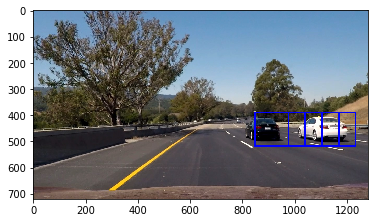

In [22]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_bb(draw_image, hot_windows, color=(0, 0, 255), thickness=6)                    

plt.imshow(window_img)

# Multiple detections and false positives

The following three functions are from Lesson 37 - Multiple Detections and False Positives

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [24]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [25]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img

# HOG Sub-sampling Window Search

The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [26]:
#The function was taken from Lesson 35 - HOG Subsampling Window search
#The function returns a list of the predicted bounding boxes
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            #test_features = hog_features.reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
            
                bbox_list.append(((xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

# Final image processing pipeline 

In [27]:
def process_image(img):
    #Define all "hyperparameters" for the feature extraction
    orient=16
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=32
    xstart=400
    xstop=1280
    ystart=360
    ystop=720
    bbox_list = []
  
    #Rescaling
    scale = 1
    bbox_list.append(find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    scale = 1.25
    bbox_list.append(find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    #Create heatmaps and apply threshold
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    return new_img

In [28]:
from moviepy.editor import VideoFileClip
test_output = "test_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:10<00:03,  3.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

Wall time: 2min 12s


In [29]:
output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:01:11<00:02,  2.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 1h 1min 12s
